# Exploring Historical Global Temperatures

This note book is an exercise based on the Kaggle dataset [Climate Change: Earth Surface Temperature Data](http://www.kaggle.com/berkeleyearth/climate-change-earth-surface-temperature-data). The raw data comes from [the Berkeley Earth data page](http://berkeleyearth.org/data/). Here I use 'LandAverageTemperature' from the dataset Global Land and Ocean-and-Land Temperatures (GlobalTemperatures.csv):

* __Date__: starts in 1750 for average land temperature and 1850 for max and min land temperatures and global ocean and land temperatures
* __LandAverageTemperature__: global average land temperature in celsius
* LandAverageTemperatureUncertainty: the 95% confidence interval around the average
* LandMaxTemperature: global average maximum land temperature in celsius
* LandMaxTemperatureUncertainty: the 95% confidence interval around the maximum land temperature
* LandMinTemperature: global average minimum land temperature in celsius
* LandMinTemperatureUncertainty: the 95% confidence interval around the minimum land temperature
* LandAndOceanAverageTemperature: global average land and ocean temperature in celsius
* LandAndOceanAverageTemperatureUncertainty: the 95% confidence interval around the global average land and ocean temperature

In this notebook, I will:

1. Import and examine the data from the CSV file
2. Model the data using an ARIMA model
3. Make predictions with the fitted model
4. Compare the performance of this ARIMA model with some baseline models

## Importing and Examining the Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as stats

%matplotlib inline

global_temp = pd.read_csv('GlobalTemperatures.csv')

Set the date to be the index, and drop NA values. 

Here I only used data starting from 1850, because I am not sure whether the data before 1850 was collected with the same method.

In [2]:
global_temp['dt'] = pd.to_datetime(global_temp['dt'])
global_temp.set_index('dt', inplace = True)
global_temp.dropna(how = 'any', inplace = True)
global_temp.head()

,LandAverageTemperature,LandAverageTemperatureUncertainty,LandMaxTemperature,LandMaxTemperatureUncertainty,LandMinTemperature,LandMinTemperatureUncertainty,LandAndOceanAverageTemperature,LandAndOceanAverageTemperatureUncertainty
dt,,,,,,,,
1850-01-01,0.749,1.105,8.242,1.738,-3.206,2.822,12.833,0.367
1850-02-01,3.071,1.275,9.970,3.007,-2.291,1.623,13.588,0.414
1850-03-01,4.954,0.955,10.347,2.401,-1.905,1.410,14.043,0.341
1850-04-01,7.217,0.665,12.934,1.004,1.018,1.329,14.667,0.267
1850-05-01,10.004,0.617,15.655,2.406,3.811,1.347,15.507,0.249


In [3]:
global_temp['LandAverageTemperature'].tail()

dt
2015-08-01    14.755
2015-09-01    12.999
2015-10-01    10.801
2015-11-01     7.433
2015-12-01     5.518
Name: LandAverageTemperature, dtype: float64

A quick look at the land average temperature data. I am especially interested in seeing whether this time series is stationary.

Augmented Dickey-Fuller unit root test:
H0: there is a unit root, ie. non-stationary
Ha: there is no unit root (usually equivalent to stationarity or trend stationarity)

/home/peizzz/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:12: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=False,window=12).mean()
/home/peizzz/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:13: FutureWarning: pd.rolling_var is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=False,window=12).var()


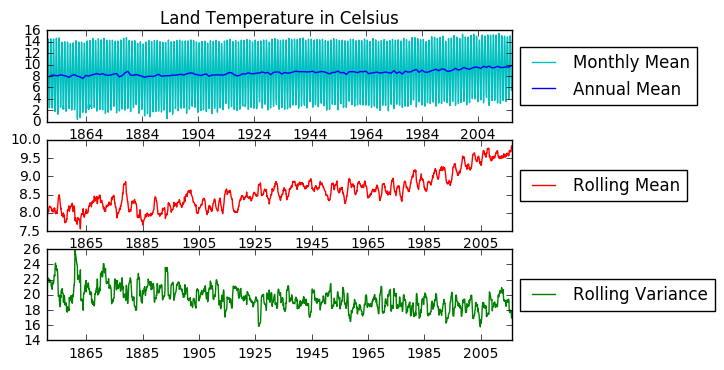

Results of Dickey-Fuller Test on Monthly Mean:
Test Statistic                   -1.455328
p-value                           0.555483
#Lags Used                       26.000000
Number of Observations Used    1965.000000
Critical Value (5%)              -2.863012
Critical Value (1%)              -3.433682
Critical Value (10%)             -2.567554
dtype: float64


In [5]:
fig = plt.figure()

plt.subplot(311)
plt.title('Land Temperature in Celsius')
plt.plot(global_temp['LandAverageTemperature'], color = 'c', label = 'Monthly Mean')
plt.plot(global_temp['LandAverageTemperature'].resample('A').mean(), color = 'b', label = 'Annual Mean')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))



# Adding rolling mean
rolmean = pd.rolling_mean(global_temp['LandAverageTemperature'], window=12)
rolvar = pd.rolling_var(global_temp['LandAverageTemperature'], window=12)

plt.subplot(312)
plt.plot(rolmean, label = 'Rolling Mean', color = 'r')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

plt.subplot(313)
plt.plot(rolvar, label = 'Rolling Variance', color = 'g')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

# Augmented Dickey-Fuller Test for stationarity.
def stationarity_test(s, name = None):
    if name != None:
        print('Results of Dickey-Fuller Test on %s:'%name)
    else:
        print('Results of Dickey-Fuller Test:')
    
    df_test = sm.tsa.stattools.adfuller(s)
    df_result = pd.Series(df_test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in df_test[4].items():
        df_result['Critical Value (%s)'%key] = value
    print(df_result)

stationarity_test(global_temp['LandAverageTemperature'], 'Monthly Mean')

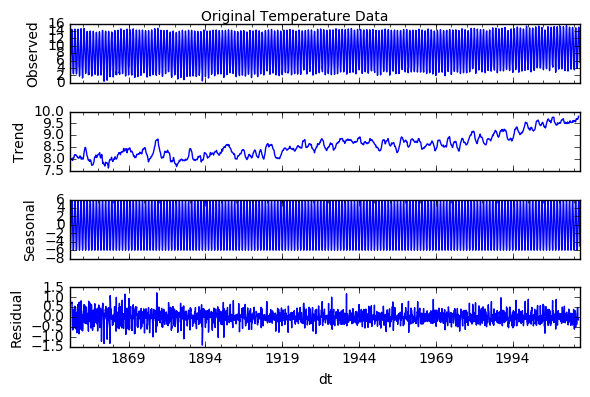

In [6]:
decomposition = sm.tsa.seasonal_decompose(global_temp['LandAverageTemperature'], model='additive')  
fig = plt.figure()  
fig = decomposition.plot()
plt.suptitle('Original Temperature Data')


This data is not stationary. It has an upward trend and strong seasonality. Thus I will first attempt to remove seasonality. As seen below, a seasonal (12 months) difference alone makes the stationarity test statistic smaller than the 1% critical values.

In [7]:
temp_diff12 = global_temp['LandAverageTemperature'] - global_temp['LandAverageTemperature'].shift(12)
temp_diff12.dropna(inplace = True)
stationarity_test(temp_diff12, 'Temperature - 12 Month Difference')


Results of Dickey-Fuller Test on Temperature - 12 Month Difference:
Test Statistic                -1.278337e+01
p-value                        7.334162e-24
#Lags Used                     2.400000e+01
Number of Observations Used    1.955000e+03
Critical Value (5%)           -2.863020e+00
Critical Value (1%)           -3.433699e+00
Critical Value (10%)          -2.567558e+00
dtype: float64


/home/peizzz/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=False,window=12).mean()
/home/peizzz/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:11: FutureWarning: pd.rolling_var is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=False,window=12).var()


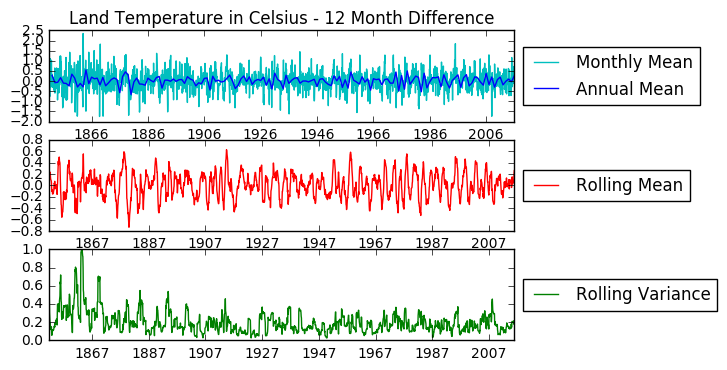

In [8]:
fig = plt.figure()

plt.subplot(311)
plt.title('Land Temperature in Celsius - 12 Month Difference')
plt.plot(temp_diff12, color = 'c', label = 'Monthly Mean')
plt.plot(temp_diff12.resample('A').mean(), color = 'b', label = 'Annual Mean')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

# Adding rolling mean
rolmean = pd.rolling_mean(temp_diff12, window=12)
rolvar = pd.rolling_var(temp_diff12, window=12)

plt.subplot(312)
plt.plot(rolmean, label = 'Rolling Mean', color = 'r')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

plt.subplot(313)
plt.plot(rolvar, label = 'Rolling Variance', color = 'g')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

Now the data is stationarized, we can proceed to data modeling.

## Modeling the Data (Seasonal ARIMA)

The autoregressive integrated moving average (ARIMA) model is a model often used for analyzing time series data. In this notebook, I will try to use an ARIMA model to model the temperature data above, and use the model to predict the temperatures within and out of the time range of this historical data.

I start by examining the ACF and PACF plots of the seasonal differentiated data:

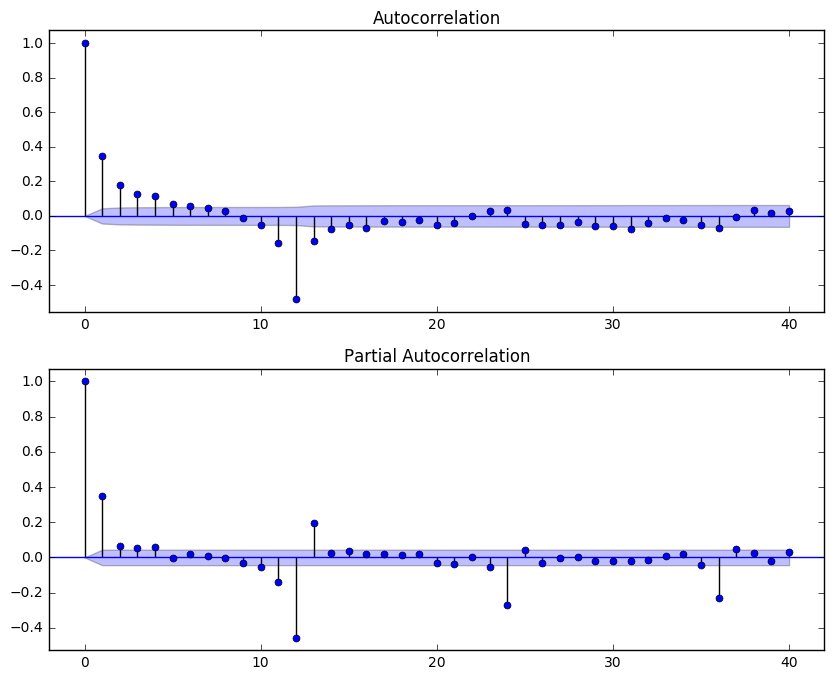

In [9]:
fig = plt.figure(figsize = (10, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(temp_diff12, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(temp_diff12, lags=40, ax=ax2)

The seasonal part of the model has a MA(1) term, since there is a spike at lag 12 in the ACF but no other significant spikes, and the PACF shows exponential decay at lag 12x. The non-seasonal part has a AR(2) term, but the MA term is less obvious. After experimenting with the non-seasonal MA term below, I decided the ARIMA(2,0,2)(0,1,1)12 gives the best results. (The experimenting code is commentted out in order to save some run time of this notebook.)

In [10]:
# mod000 = sm.tsa.statespace.SARIMAX(global_temp['LandAverageTemperature'], order=(0,0,0), 
#                                    seasonal_order=(0,1,1,12), enforce_stationarity = False, 
#                                    enforce_invertibility = False).fit()

# mod201 = sm.tsa.statespace.SARIMAX(global_temp['LandAverageTemperature'], order=(2,0,1), 
#                                    seasonal_order=(0,1,1,12), enforce_stationarity = False, 
#                                    enforce_invertibility = False).fit()


# mod202 = sm.tsa.statespace.SARIMAX(global_temp['LandAverageTemperature'], order=(2,0,2), 
#                                    seasonal_order=(0,1,1,12), enforce_stationarity = False, 
#                                    enforce_invertibility = False).fit()


# mod205 = sm.tsa.statespace.SARIMAX(global_temp['LandAverageTemperature'], order=(2,0,5), 
#                                    seasonal_order=(0,1,1,12), enforce_stationarity = False, 
#                                    enforce_invertibility = False).fit()

# print('Model', 'AIC', 'BIC', 'HQIC')
# for i in range(4):
#     mods = [mod000, mod201, mod202, mod205]
#     mod_names = ['(0,0,0)', '(2,0,1)', '(2,0,2)', '(2,0,5)']    
#     print('ARIMA' + mod_names[i] + 'x(0,1,1)_12', mods[i].aic, mods[i].bic, mods[i].hqic)


## Out:
## Model AIC BIC HQIC
## ARIMA(0,0,0)x(0,1,1)_12 1718.88434628 1730.07813515 1722.99530443
## ARIMA(2,0,1)x(0,1,1)_12 1258.33364589 1286.31811808 1268.61104126
## ARIMA(2,0,2)x(0,1,1)_12 1249.70453329 1283.28589992 1262.03740774
## ARIMA(2,0,5)x(0,1,1)_12 1259.46169646 1309.8337464 1277.96100813

In [11]:
mod202 = sm.tsa.statespace.SARIMAX(global_temp['LandAverageTemperature'], order = (2, 0, 2), 
                                   seasonal_order=(0,1,1,12), enforce_stationarity = False, 
                                   enforce_invertibility = False).fit()
print('Model', 'AIC', 'BIC', 'HQIC')
print('ARIMA(2,0,2)x(0,1,1)_12', mod202.aic, mod202.bic, mod202.hqic)

Model AIC BIC HQIC
ARIMA(2,0,2)x(0,1,1)_12 1249.70453329 1283.28589992 1262.03740774


In [12]:
print(mod202.summary())

                                 Statespace Model Results                                 
Dep. Variable:             LandAverageTemperature   No. Observations:                 1992
Model:             SARIMAX(2, 0, 2)x(0, 1, 1, 12)   Log Likelihood                -618.852
Date:                            Thu, 02 Mar 2017   AIC                           1249.705
Time:                                    13:24:21   BIC                           1283.286
Sample:                                01-01-1850   HQIC                          1262.037
                                     - 12-01-2015                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.5565   1.69e+05   9.22e-06      1.000   -3.31e+05    3.31e+05
ar.L2         -0.5577   2.01e+05  -

Now I analyze the residuals of the ARIMA(2,0,2)x(0,1,1)_12 model.

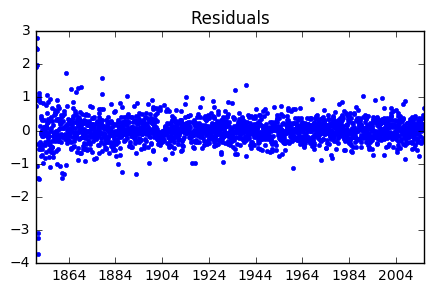

In [86]:
fig = plt.figure(figsize = (5, 3))
resid202 = mod202.resid
plt.plot(resid202, 'b.')
plt.title('Residuals')
plt.show()

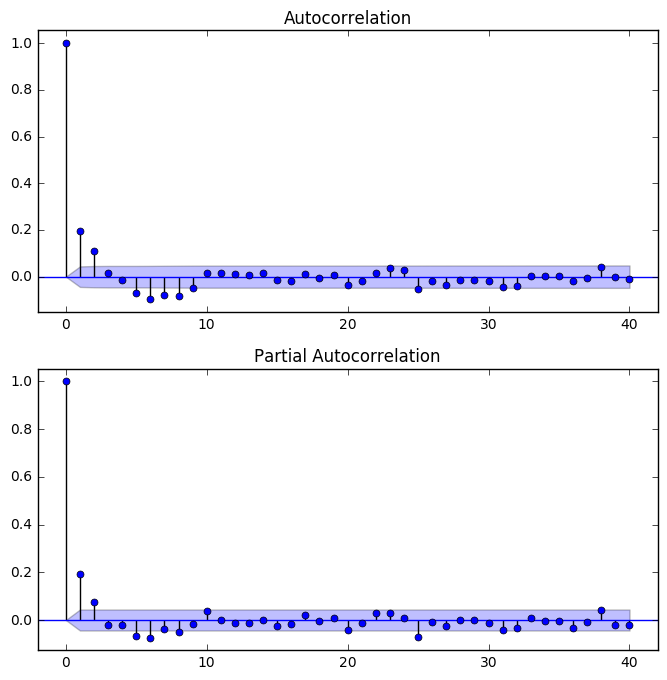

In [14]:
fig = plt.figure(figsize = (8, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(resid202, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(resid202, lags=40, ax=ax2)

Neither the ACF or PACF plots of the residuals showed any spikes beside lag 0, indicating the residuals are not autocorrelated.

For the normal test below, the H0 is that a sample comes from a normal distribution.

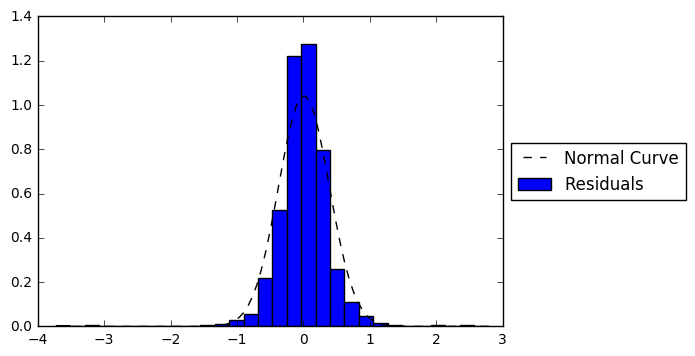

NormaltestResult(statistic=463.76425536589068, pvalue=1.9718391964105937e-101)


In [139]:
def fit_norm(data):
    '''Fits a Normal distribution to 1D data.'''
    mu, std = stats.norm.fit(data)
    x = np.linspace(np.min(data),np.max(data),100)
    y = stats.norm.pdf(x, mu, std)
    return (x, y)


plt.figure()
plt.hist(resid202, bins = 30, normed = True, label = 'Residuals')
x, y = fit_norm(resid202)
plt.plot(x, y,'k--', label = 'Normal Curve')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

print(stats.normaltest(resid202))

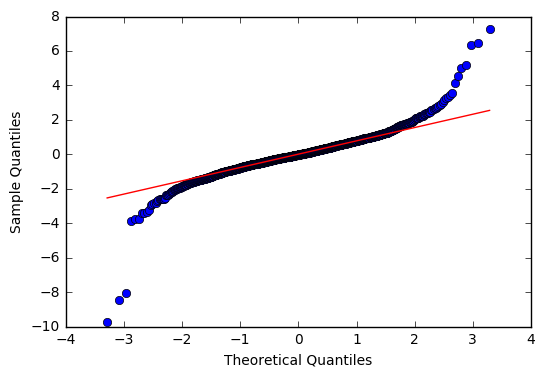

In [16]:
fig = plt.figure()
ax = sm.graphics.qqplot(resid202, line='q', fit=True)

From the normal test and the Q-Q plot, we can see the residuals are heavy tailed.

## Making Predictions

I use this ARIMA(2,0,2)x(0,1,1)\_12 model from above to make in-sample and out-of-sample predictions. The date of last entry in the historical data is 2015-12-01. We will make a five year prediction afterwards only for the sake of learning. Of courese in reality, five-year-ahead weather prediction is almost guaranteed unrealiable. 

/home/peizzz/miniconda3/lib/python3.5/site-packages/statsmodels/base/data.py:551: FutureWarning: TimeSeries is deprecated. Please use Series
  return TimeSeries(squeezed, index=self.predict_dates)
/home/peizzz/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: FutureWarning: pd.rolling_mean is deprecated for TimeSeries and will be removed in a future version, replace with 
	TimeSeries.rolling(center=False,window=12).mean()
/home/peizzz/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:11: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=False,window=12).mean()


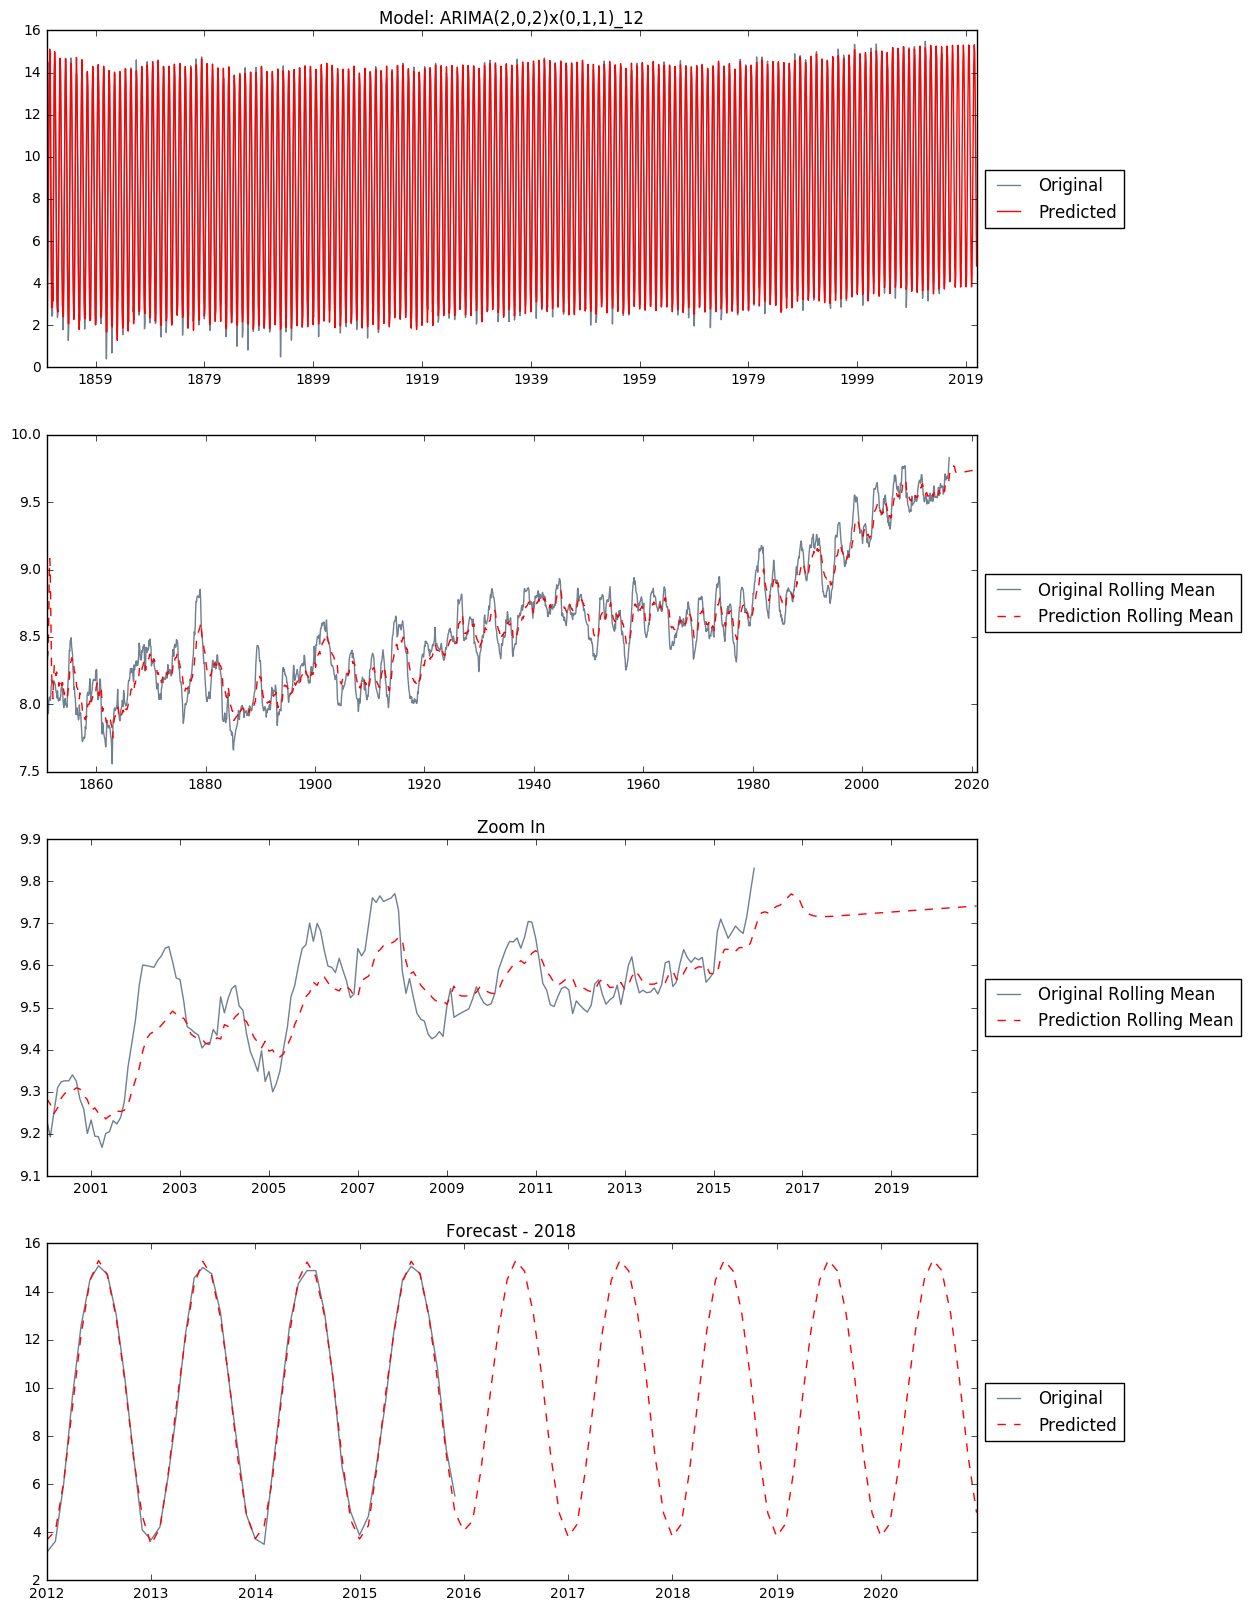

In [25]:
predict_mod202 = mod202.predict('1850-01-01', '2020-12-01')

fig, axs = plt.subplots(4, figsize = (12, 20))
axs[0].set_title('Model: ARIMA(2,0,2)x(0,1,1)_12')
axs[0].plot(global_temp['LandAverageTemperature'], color = 'slategray', label = 'Original')
axs[0].plot(predict_mod202, color = 'red', label = 'Predicted')
axs[0].legend(loc='center left', bbox_to_anchor=(1.0, 0.5))


predict_rolmean = pd.rolling_mean(predict_mod202, window=12)
original_rolmean = pd.rolling_mean(global_temp['LandAverageTemperature'], window=12)

axs[1].plot(original_rolmean, color = 'slategray', label = 'Original Rolling Mean')
axs[1].plot(predict_rolmean, color = 'red', linestyle = '--', label='Prediction Rolling Mean')
axs[1].legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

axs[2].set_title('Zoom In')
axs[2].plot(original_rolmean['2000':], color = 'slategray', label = 'Original Rolling Mean')
axs[2].plot(predict_rolmean['2000':], color = 'red', linestyle = '--', label='Prediction Rolling Mean')
axs[2].legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

axs[3].set_title('Forecast - 2018')
axs[3].plot(global_temp['LandAverageTemperature']['2012':'2020'], color = 'slategray', label = 'Original')
axs[3].plot(predict_mod202['2012':'2020'], color='red', linestyle = '--', label = 'Predicted')
axs[3].legend(loc='center left', bbox_to_anchor=(1.0, 0.5))


## Baseline Comparison

Now I have a working model, I would like to see how it compares against some baseline models. Nate Silver mentions in his book "The Signal and the Noise" with respect to weather forecasting: 

"There are two basic tests that any weather forecast must pass to demonstrate its merit: 
1. It must do better than what meteorologists call persistence: the assumption that the weather will be the same tomorrow (and the next day) as it was today. 
2. It must also beat climatology, the long-term historical average of conditions on a particular date in a particular area."

Thus I will build these two baseline models accordingly for comparison. 

### Alt Model 1: Persistence

In this model, each month's temperature is predicted to be the same as that of the previous month.

In [41]:
predict_dates = pd.date_range(start = '1850-01-01', end ='2020-12-01', freq='MS')
predict_altmod1 = pd.DataFrame(index = predict_dates, columns = ['forecast', 'observed', 'resid'])
predict_altmod1['observed'] = global_temp['LandAverageTemperature']

predict_altmod1['forecast'] = global_temp['LandAverageTemperature'].shift(1)
predict_altmod1.loc['1850-01-01', 'forecast'] = global_temp.loc['1850-01-01', 'LandAverageTemperature']
last_observed = global_temp['LandAverageTemperature'].iloc[-1] 
# all out-of-sample predictions are the same as the last temperature entry in the original data set (observed)
predict_altmod1['forecast'].fillna(last_observed, inplace = True) 

predict_altmod1['resid'] = predict_altmod1['observed'] - predict_altmod1['forecast']

print(predict_altmod1.head(20))
print(predict_altmod1.tail(20))


            forecast  observed  resid
1850-01-01     0.749     0.749  0.000
1850-02-01     0.749     3.071  2.322
1850-03-01     3.071     4.954  1.883
1850-04-01     4.954     7.217  2.263
1850-05-01     7.217    10.004  2.787
1850-06-01    10.004    13.150  3.146
1850-07-01    13.150    14.492  1.342
1850-08-01    14.492    14.039 -0.453
1850-09-01    14.039    11.505 -2.534
1850-10-01    11.505     8.091 -3.414
1850-11-01     8.091     4.733 -3.358
1850-12-01     4.733     2.803 -1.930
1851-01-01     2.803     2.431 -0.372
1851-02-01     2.431     2.508  0.077
1851-03-01     2.508     4.192  1.684
1851-04-01     4.192     7.287  3.095
1851-05-01     7.287    11.113  3.826
1851-06-01    11.113    13.418  2.305
1851-07-01    13.418    14.531  1.113
1851-08-01    14.531    13.751 -0.780
            forecast  observed  resid
2019-05-01     5.518       NaN    NaN
2019-06-01     5.518       NaN    NaN
2019-07-01     5.518       NaN    NaN
2019-08-01     5.518       NaN    NaN
2019-09-01  

### Alt Model 2: Overly Simplified Seasonal

In this model, each month's temperature is predicted to be the mean of all historical temperatures of the same month of the year. Eg. the predicted temperature of January 2016 would be the mean of all January temperatures from 1851 to 2015; the predicted temperature of February 2017 would be the mean of all February temperatures from 1851 to 2016, and so on.

In [47]:
predict_dates = pd.date_range(start = '1850-01-01', end ='2020-12-01', freq='MS')
df = pd.DataFrame(index = predict_dates, columns = ['forecast', 'observed'])
df['observed'] = global_temp['LandAverageTemperature']

df_list = []
for m in range(1, 13):
    newdf = df[df.index.month == m].copy()
    newdf['forecast']  = pd.Series.expanding(newdf['observed']).mean()
    df_list.append(newdf)
predict_altmod2 = pd.concat(df_list)
predict_altmod2.sort_index(inplace = True)

predict_altmod2['resid'] = predict_altmod2['observed'] - predict_altmod2['forecast']


print(predict_altmod2.head(20))
print(predict_altmod2.tail(20))

            forecast  observed   resid
1850-01-01    0.7490     0.749  0.0000
1850-02-01    3.0710     3.071  0.0000
1850-03-01    4.9540     4.954  0.0000
1850-04-01    7.2170     7.217  0.0000
1850-05-01   10.0040    10.004  0.0000
1850-06-01   13.1500    13.150  0.0000
1850-07-01   14.4920    14.492  0.0000
1850-08-01   14.0390    14.039  0.0000
1850-09-01   11.5050    11.505  0.0000
1850-10-01    8.0910     8.091  0.0000
1850-11-01    4.7330     4.733  0.0000
1850-12-01    2.8030     2.803  0.0000
1851-01-01    1.5900     2.431  0.8410
1851-02-01    2.7895     2.508 -0.2815
1851-03-01    4.5730     4.192 -0.3810
1851-04-01    7.2520     7.287  0.0350
1851-05-01   10.5585    11.113  0.5545
1851-06-01   13.2840    13.418  0.1340
1851-07-01   14.5115    14.531  0.0195
1851-08-01   13.8950    13.751 -0.1440
             forecast  observed  resid
2019-05-01  11.241373       NaN    NaN
2019-06-01  13.412976       NaN    NaN
2019-07-01  14.370072       NaN    NaN
2019-08-01  13.837139    

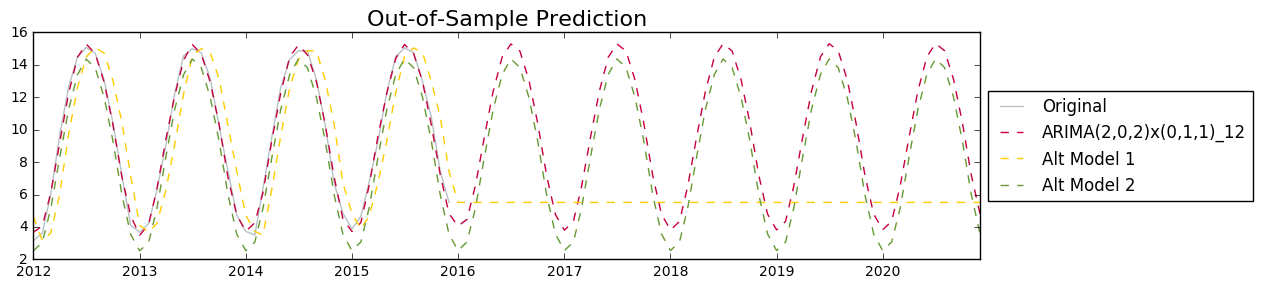

In [203]:
fig = plt.figure(figsize = (10, 3))
mod_names = ['ARIMA(2,0,2)x(0,1,1)_12', 'Alt Model 1', 'Alt Model 2']
predicts = [predict_mod202, predict_altmod1['forecast'], predict_altmod2['forecast']]
colors = ['#c70039', '#FFCC00', '#669933']

plt.plot(global_temp['LandAverageTemperature']['2012':'2020'], color = 'slategray', label = 'Original', alpha = 0.5)

for i in range(3):
    plt.plot(predicts[i]['2012':'2020'], color = colors[i], linestyle = '--', label = mod_names[i])

plt.title('Out-of-Sample Prediction', size = 16)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
fig.tight_layout()
plt.show()

### Residual Analysis

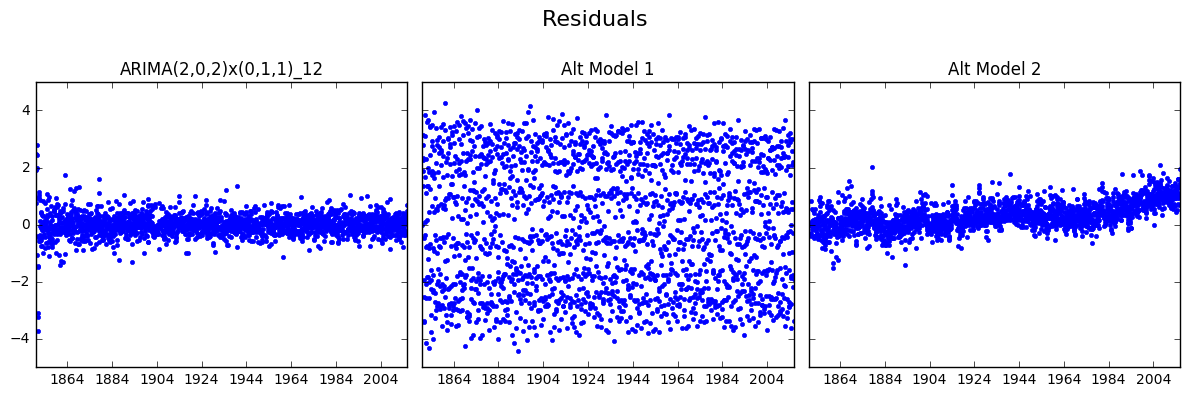

In [110]:
fig, axs = plt.subplots(1, 3, sharey = True, figsize = (12, 4))
resids = [resid202, predict_altmod1['resid'].dropna(), predict_altmod2['resid'].dropna()]

for i in range(3):
    axs[i].set_title(mod_names[i])
    axs[i].plot(resids[i], 'b.')

fig.suptitle('Residuals', size = 16)
fig.tight_layout()
fig.subplots_adjust(top = 0.8)
plt.show()

We can see from the figures above that the Alt Model 1 (Persistence) has very scattered residuals (aka the errors are large). The residuals of Alt Model 2 (Overly Simplified Seasonal) seems to have a upward trend, which is undesirable.

ARIMA(2,0,2)x(0,1,1)_12 NormaltestResult(statistic=463.76425536589068, pvalue=1.9718391964105937e-101)
Alt Model 1 NormaltestResult(statistic=39154.279102240027, pvalue=0.0)
Alt Model 2 NormaltestResult(statistic=43.638821605600526, pvalue=3.3415678972003915e-10)


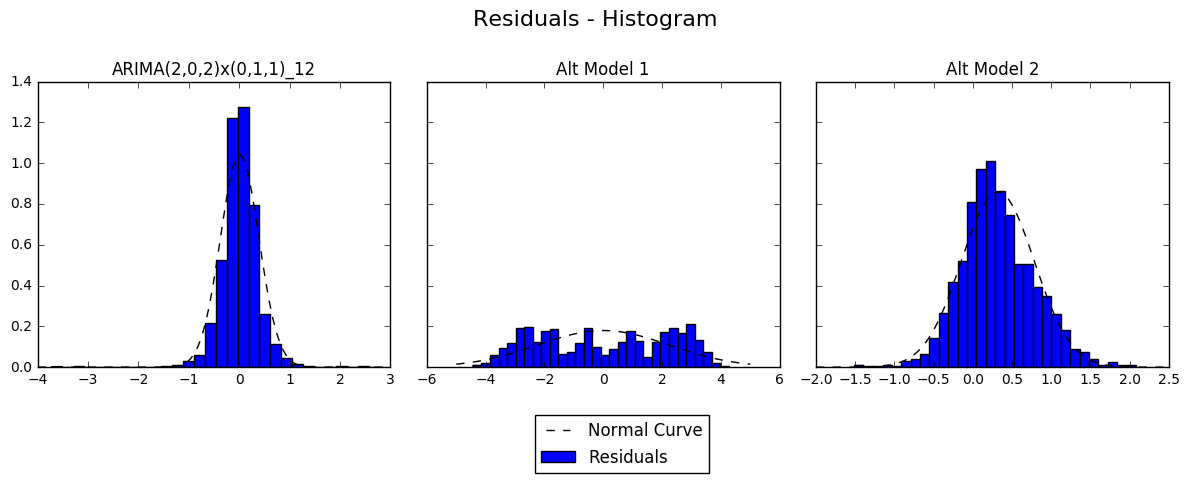

In [126]:
fig, axs = plt.subplots(1, 3, sharey = True, figsize = (12, 4))

for i in range(3):
    plt.sca(axs[i])
    axs[i].set_title(mod_names[i])
    plt.hist(resids[i], bins = 30, normed = True, label = 'Residuals')
    
    x, y = fit_norm(resids[i])
    plt.plot(x, y,'k--', label = 'Normal Curve')
    
    print(mod_names[i], stats.normaltest(resids[i]))

fig.suptitle('Residuals - Histogram', size = 16)
plt.legend(loc='lower center', bbox_to_anchor=(-0.55, -0.4))
fig.tight_layout()
fig.subplots_adjust(top = 0.8)
plt.show()


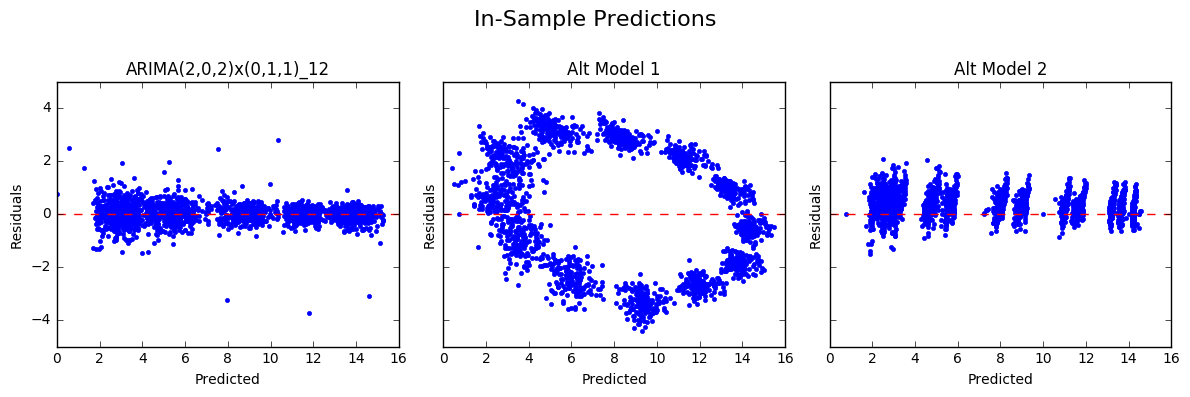

In [143]:
fig, axs = plt.subplots(1, 3, sharey = True, figsize = (12, 4))

for i in range(3):
    plt.sca(axs[i])
    axs[i].set_title(mod_names[i])
    axs[i].set_xlabel('Predicted')
    axs[i].set_ylabel('Residuals')
    axs[i].plot(predicts[i][:'2015-12-01'], resids[i], 'b.')
    plt.axhline(y = 0, color='red', linestyle = '--')

fig.suptitle('In-Sample Predictions', size = 16)
fig.tight_layout()
fig.subplots_adjust(top = 0.8)
plt.show()

In the plots of the residuals against the fitted values above, we can see both of the alternative models showed patterns (again, undesirable), whereas the seasonal ARIMA model produced residuals scattered randomly around the line y = 0 (expected). 

###  Forecast Performance:

I will evaluate the forecast performance of these three model using two of the most commonly used measures, RMSE (root mean squared error) and MAE (mean absolute error).

In [206]:
print('{:<30s}{:<10s}{:<10s}'.format('Model', 'RMSE', 'MAE'))
print('-' * 50)

for i in range(3):
    print('{:<30s}{:<10.4f}{:<10.4f}'.format(mod_names[i], 
                                    sm.tools.eval_measures.rmse(global_temp['LandAverageTemperature'], 
                                                                predicts[i][:'2015-12-01']),
                                    sm.tools.eval_measures.meanabs(global_temp['LandAverageTemperature'], 
                                                                    predicts[i][:'2015-12-01'])))

Model                         RMSE      MAE       
--------------------------------------------------
ARIMA(2,0,2)x(0,1,1)_12       0.3831    0.2626    
Alt Model 1                   2.2259    1.9782    
Alt Model 2                   0.5635    0.4339    


Now we are confident that the seasonal ARIMA model out performs both of the baseline models.